In [150]:
#libraries:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp
import seaborn as sns

In [151]:
#DATA MANAGMENT
#loading data as array:
df = np.loadtxt("OGLE-2024-BLG-0393.dat", dtype=float)

#extracting measurments (time in HJD-2450000, I in Magnitude)
t,M,M_err = (df[:,0]-2450000.0),df[:,1],df[:,2]
M_base = np.mean(M[:50])
#converting apparent magnitude to flux and reversed:
MTF = lambda m: 10**(-0.4*(m-M_base))
FTM = lambda F: -2.5*np.log10(F)+M_base
F_err = lambda m, m_err: np.abs((-0.4)*np.log(10)*10**(-0.4*(m-M_base))*m_err)
m_err = lambda f, f_err: np.abs(((-0.4)*np.log(10)*10**(-0.4*FTM(f)))**(-1))*f_err

In [152]:
#Theoretical equations:
A = lambda u: (u**2 + 2)/(u*(u**2 + 4)**0.5)

u_from_A = lambda A: (2 * (A / (A**2 - 1)**0.5 - 1))**0.5 #assuming A>1

u = lambda t,t_0,u_min,tau: (u_min**2 + ((t-t_0)/tau)**2)**0.5

I = lambda A,f_bl: f_bl*A + (1-f_bl)

### First Part:

In [153]:
#FIRST PART FUNCTIONS:

#isolating data around peak:
def peak_data(x,y,y_err,width_right,width_left):
    #y maximum index:
    peak_idx = np.argmin(y) 

    #edges indices of peak
    start_idx =  peak_idx - width_right
    end_idx = peak_idx + width_left

    #getting the data around the peak
    x_peak_data = x[start_idx:end_idx]
    y_peak_data = y[start_idx:end_idx]
    y_err_peak_data = y_err[start_idx:end_idx]

    return x_peak_data,y_peak_data,y_err_peak_data
      
#linear list square fit for y = ax^2 + bx + c
def parabolic_LLS(y,y_error,x):

    #fixing issue of large numbers by shifting x data to center
    x_centered = x - np.mean(x)

    #weight matrix: 
    W = np.diag(1.0/(y_error**2))

    # x^2 + x + 1 matrix
    F_centered = np.column_stack((x_centered**2,x_centered,np.ones_like(x_centered)))

    #covariance matrix: C = (F_T * W * F)^-1
    C_centered = np.linalg.pinv(np.transpose(F_centered) @ W @ F_centered)

    # jacobian to revert back to original x parameters and results:
    J = np.array([  [1,          0,    0],  # converting a
                    [-2*np.mean(x), 1,    0], # converting b
                    [np.mean(x)**2, -np.mean(x), 1] ])  # converting c
        

    # 4. Calculate the new Covariance Matrix: J @ C @ J_Transpose
    C_original = J @ C_centered @ J.T
    
    #parameters matrix for minimum chi 2: P = (F_T * W * F)^-1 * (F_T * W * y)
    P = J @ C_centered @ (np.transpose(F_centered) @ W @ y)

    #parameters error matrix:
    P_err = np.sqrt(np.diag(C_original))

    #y fitted to model:
    y_fit = lambda x :np.polyval(P, x)

    #degrees of freedom
    dof = len(x)-len(P)
    #chi square calculation:
    chi_2 = np.sum(np.square(y_fit(x) - y) @ W)
    chi_2_red =chi_2/dof
    #P value calculation
    P_value = sp.chi2.sf(chi_2, dof)

    return P,P_err,y_fit,chi_2_red,P_value

#parabolic bootstrap function:
def parabolic_bootstrap(y,y_err,x):
    param_boot_array = []
    for i in range(1000):

        indices = np.random.randint(0, len(y), size=len(y))

        # Create the resampled dataset
        x_boot = x[indices]
        y_boot = y[indices]
        y_err_boot = y_err[indices]

        param, _, _, _, _ = parabolic_LLS(y_boot, y_err_boot, x_boot)

        t_0 = -param[1]/(2*param[0])

        A_max = np.polyval(param,t_0)

        if A_max >= 3/np.sqrt(5) and param[0]<0 and len(np.unique(x_boot))>3:

            #assuming f_bl = 1:
            u_min = u_from_A(A_max)

            #calculating tau:
            a,b,c = param[0],param[1],param[2] - 3/np.sqrt(5)
            tau = abs(((-b + np.sqrt(b**2 - 4*a*c)) / (2 * a)) - t_0)/np.sqrt(1-u_min**2)

            param_boot_array.append([t_0,u_min,tau])

    param_boot_array = np.array(param_boot_array)
    t_0_array = param_boot_array[:, 0]
    u_0_array = param_boot_array[:, 1]
    tau_array = param_boot_array[:, 2] 

    # Remove NaNs from tau_array for mean/std calculation
    t_0_array_clean = t_0_array[~np.isnan(t_0_array)]
    u_0_array_clean = u_0_array[~np.isnan(u_0_array)]
    tau_array_clean = tau_array[~np.isnan(tau_array)]

    param_boot = [
        (t_0_array_clean), 
        (u_0_array_clean), 
        (tau_array_clean)
    ]
    return param_boot

In [154]:
#isolating data around peak
t_around_peak,M_around_peak, M_around_peak_err = peak_data(t,M,M_err,4,4)

#converting measurments to flux
f_around_peak = MTF(M_around_peak)
f_around_peak_err = F_err(M_around_peak,M_around_peak_err)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


P_value = 0.5543455396826573


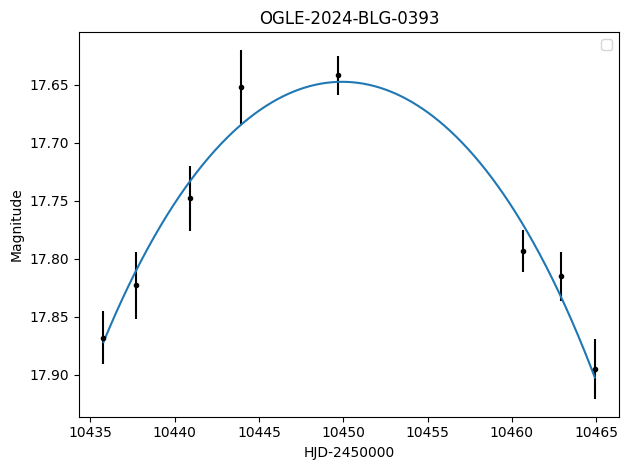

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


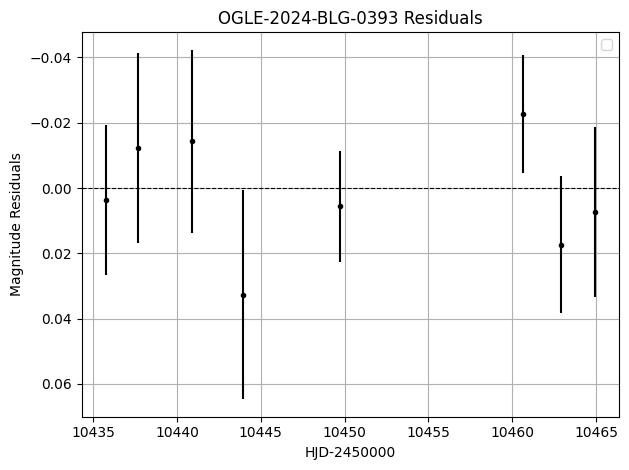

In [155]:
#PLOTTING PARABOLIC FIT(NO BOOTSTRAP)

Param,Param_err,y_fit,chi_2_red,P_value = parabolic_LLS(y=f_around_peak,y_error=f_around_peak_err,x=t_around_peak)
print(f'P_value = {P_value}')
#plotting fit:

plt.gca().invert_yaxis()
plt.errorbar(t_around_peak,M_around_peak, M_around_peak_err,fmt="." ,color="black")
plt.plot(np.linspace(min(t_around_peak),max(t_around_peak),1000) ,FTM(y_fit(np.linspace(min(t_around_peak),max(t_around_peak),1000))))
plt.title('OGLE-2024-BLG-0393')
plt.ylabel("Magnitude")
plt.xlabel('HJD-2450000')
plt.legend()
plt.tight_layout()
plt.savefig("Parabolic Fit Around Peak 0393")
plt.show()

#plotting residuals:
plt.gca().invert_yaxis()
plt.errorbar(t_around_peak,FTM(y_fit(t_around_peak))-M_around_peak, M_around_peak_err,fmt="." ,color="black")
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.xlabel("HJD-2450000")
plt.ylabel("Magnitude Residuals")
plt.title('OGLE-2024-BLG-0393 Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Parabolic Residuals Around Peak 0393')
plt.show()

t_0 average = 10449.86391525029 t_0 std = 1.0589518751931328


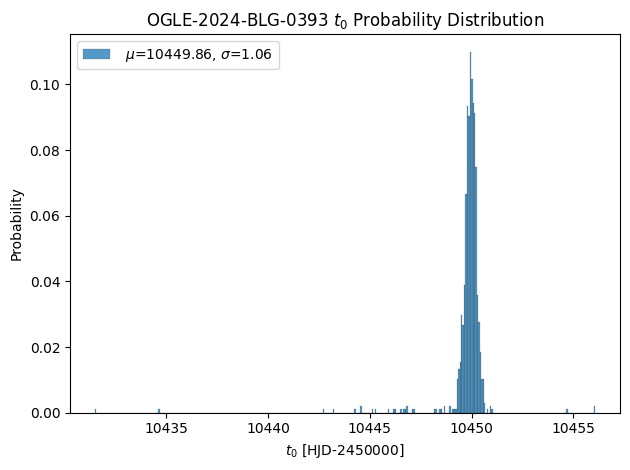

u_min average = 0.25628688360114443 u_min std = 0.004356467201753975


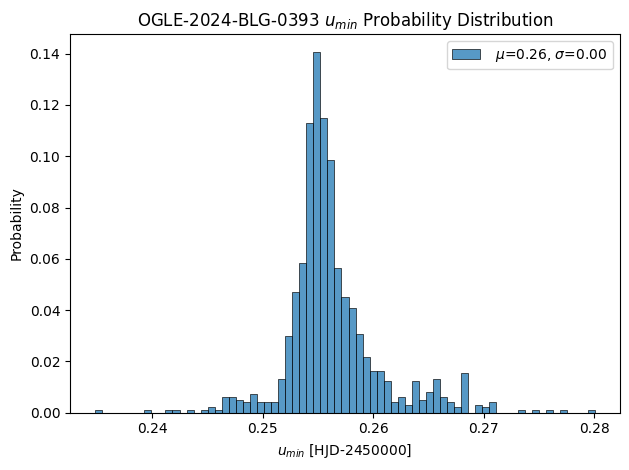

tau average = 28.016437214349796 tau std = 2.2387555957141676


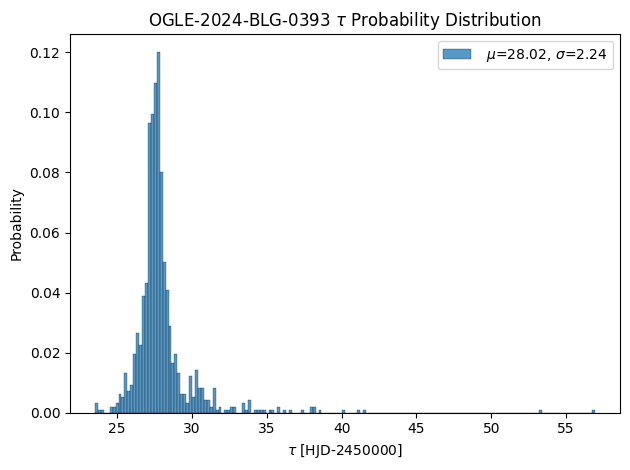

In [156]:
#PLOTTING BOOTSTRAP HISTOGRAMS
param_boot_array = parabolic_bootstrap(f_around_peak,f_around_peak_err,t_around_peak)

#creating graphs and average +std:
def hist(data,name):
    #calculating mean and std
    mean,std = np.mean(data),np.std(data)
    
   
    sns.histplot(data,stat='probability',label=f' $\mu$={mean:.2f}, $\sigma$={std:.2f}',bins="auto")
    
    clean_name = name.replace('$', '').replace('\\', '').replace('{', '').replace('}', '')

    #printing results
    print(f'{clean_name} average = {mean}', f'{clean_name} std = {std}')

    plt.xlabel(f'{name} [HJD-2450000]')
    plt.ylabel("Probability")
    plt.title(f'OGLE-2024-BLG-0393 {name} Probability Distribution')
    plt.tight_layout()
    plt.legend()
    plt.savefig(f'boot strap {clean_name} 0393')
    plt.show()

hist(param_boot_array[0],r'$t_{0}$')
hist(param_boot_array[1],r'$u_{min}$')
hist(param_boot_array[2],r'$\tau$')

### Second Part: